In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.
/Users/mariela/opt/anaconda3/envs/Deeplearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mariela/opt/anaconda3/envs/Deeplearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mariela/opt/anaconda3/envs/Deeplearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [3]:

# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [4]:
data = read_text("spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

In [5]:
spa_eng = spa_eng[:50000,:]

In [6]:
spa_eng

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['I am waiting for my driver.', 'Estoy esperando a mi chofer.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1661151 (Amastan) & #1669102 (marcelostockle)'],
       ['I appreciate all your help.', 'Aprecio toda tu ayuda.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933632 (CK) & #4788227 (DarkHollow)'],
       ['I appreciate your interest.', 'Agradezco tu interés.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933576 (CK) & #4394520 (teskmon)']],
      dtype='<U332')

In [7]:
import numpy

In [8]:
#Remove author
spa_eng = numpy.delete(spa_eng, numpy.s_[2], axis=1) 

In [9]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [10]:
spa_eng

array([['Go', 'Ve'],
       ['Go', 'Vete'],
       ['Go', 'Vaya'],
       ...,
       ['I am waiting for my driver', 'Estoy esperando a mi chofer'],
       ['I appreciate all your help', 'Aprecio toda tu ayuda'],
       ['I appreciate your interest', 'Agradezco tu interés']],
      dtype='<U332')

In [11]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [12]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [13]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))

       eng  spa
0        1    1
1        1    1
2        1    1
3        1    1
4        1    1
...    ...  ...
49995    6    5
49996    8    6
49997    6    5
49998    5    4
49999    4    3

[50000 rows x 2 columns]
8
12


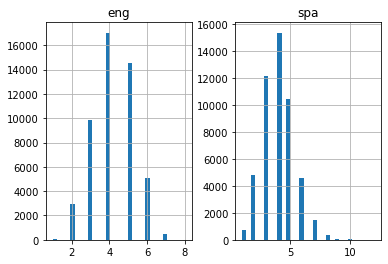

In [14]:
length_df.hist(bins = 30)
plt.show()

In [15]:
#The maximum length of the Spanish sentences is 12 and that of the English phrases is 8.

In [16]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [17]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6942


In [18]:
# prepare Spanish tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 14196


In [19]:
#print(spa_tokenizer.word_counts)

In [20]:
#print(eng_tokenizer.word_counts)

In [21]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

In [22]:
##Model Building

In [23]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

In [24]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])


[[   1   10 1574 ...    0    0    0]
 [4836    4    6 ...    0    0    0]
 [  14 4963    0 ...    0    0    0]
 ...
 [  43  199 1665 ...    0    0    0]
 [  18   12   15 ...    8 1196    0]
 [   2  240 1475 ...    0    0    0]]
40000
[[   3  182   10 ...    0    0    0]
 [   1 1094    6 ...    0    0    0]
 [  50  101    9 ...    0    0    0]
 ...
 [  44  444  432 ...    0    0    0]
 [  22    4  123 ...  213    0    0]
 [   1  202 2244 ...    0    0    0]]
40000


In [25]:
print(trainX.shape)
print(trainY.shape)

(40000, 8)
(40000, 8)


In [26]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[  53   43   28 ...    0    0    0]
 [ 233    4    1 ...    0    0    0]
 [ 108 8599    0 ...    0    0    0]
 ...
 [9604  115  974 ...    0    0    0]
 [1347   55  598 ...    0    0    0]
 [   2   31 6750 ...    0    0    0]]
10000
[[  36   16   40 ...    0    0    0]
 [   1   37    3 ...    0    0    0]
 [   2   99 1339 ...    0    0    0]
 ...
 [  56 1781   29 ...    0    0    0]
 [  33    2  217 ...    0    0    0]
 [   1  867   42 ...    0    0    0]]
10000


In [27]:
print(testX.shape)
print(testY.shape)

(10000, 8)
(10000, 8)


In [28]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [29]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

14196
6942
8
8


In [30]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
filename = 'model.h1.sept_2021'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=10, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

2021-09-26 02:49:37.607128: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-26 02:49:37.611023: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Train on 32000 samples, validate on 8000 samples
Epoch 1/10


2021-09-26 02:49:39.087713: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2021-09-26 02:49:39.096761: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iteration = 1, topological sort failed with message: The graph couldn't be sorted in topological order.
2021-09-26 02:49:39.238653: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:502] remapper failed: Invalid argument: The graph couldn't be sorted in topological order.
2021-09-26 02:49:39.247808: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:502] arithmetic_optimizer failed: Invalid argument: The graph couldn't be sorted in topological order.
2021-09-26 02:49:39.255217: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2021-09-26 02:49:39.262984: E tensorflow/

31744/32000 [============================>.] - ETA: 1s - loss: 3.9297

2021-09-26 02:53:33.893546: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2021-09-26 02:53:33.895384: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iteration = 1, topological sort failed with message: The graph couldn't be sorted in topological order.
2021-09-26 02:53:33.916092: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:502] remapper failed: Invalid argument: The graph couldn't be sorted in topological order.
2021-09-26 02:53:33.917710: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:502] arithmetic_optimizer failed: Invalid argument: The graph couldn't be sorted in topological order.
2021-09-26 02:53:33.919037: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2021-09-26 02:53:33.920642: E tensorflow/

32000/32000 [==============================] - 260s 8ms/step - loss: 3.9257 - val_loss: 3.4045

Epoch 00001: val_loss improved from inf to 3.40448, saving model to model.h1.sept_2021
Epoch 2/10
32000/32000 [==============================] - 254s 8ms/step - loss: 3.2464 - val_loss: 3.2089

Epoch 00002: val_loss improved from 3.40448 to 3.20893, saving model to model.h1.sept_2021
Epoch 3/10
32000/32000 [==============================] - 253s 8ms/step - loss: 3.0902 - val_loss: 3.0868

Epoch 00003: val_loss improved from 3.20893 to 3.08676, saving model to model.h1.sept_2021
Epoch 4/10
32000/32000 [==============================] - 252s 8ms/step - loss: 2.9563 - val_loss: 2.9975

Epoch 00004: val_loss improved from 3.08676 to 2.99752, saving model to model.h1.sept_2021
Epoch 5/10
32000/32000 [==============================] - 267s 8ms/step - loss: 2.8290 - val_loss: 2.8808

Epoch 00005: val_loss improved from 2.99752 to 2.88085, saving model to model.h1.sept_2021
Epoch 6/10
32000/32000 [=

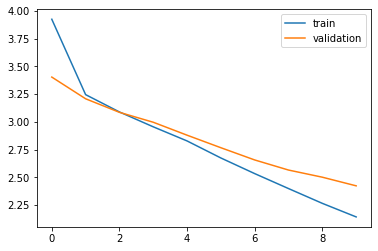

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

4 Epochs parece ser un buen numero para evitar el overfiting.
 De todas formas vemos que el loss es bastante alto por lo que podriamos trabajar con 
data pre entrenada o utilizar mas data para entrenar y menos para test
Podemos agregar dropout para evitar el problema de overfiting cuando consideremos mas epochs

In [33]:
#Make Predictions
#Let's load the saved model to make predictions.

In [48]:
#test = open("model.h1.sept_2021.csv","w",encoding='utf-8')
#model = load_model('model.h1.sept_2021')
#model = Epoch 8/10
#preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [51]:
#pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
#pd.set_option('display.max_colwidth', 200)

In [53]:
#pred_df.head(15)

In [52]:
#pred_df.sample(15)

In [ ]:
#Test 2 

In [57]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 500)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [61]:
filename = 'model.h2.sept_2021'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs= 5, 
                    batch_size= 500,
                    validation_split= 0.1,
                    callbacks=[checkpoint], 
                    verbose=1)

Train on 36000 samples, validate on 4000 samples
Epoch 1/5


2021-09-26 04:09:24.296259: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2021-09-26 04:09:24.305689: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iteration = 1, topological sort failed with message: The graph couldn't be sorted in topological order.
2021-09-26 04:09:24.445555: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:502] remapper failed: Invalid argument: The graph couldn't be sorted in topological order.
2021-09-26 04:09:24.453210: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:502] arithmetic_optimizer failed: Invalid argument: The graph couldn't be sorted in topological order.
2021-09-26 04:09:24.459987: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2021-09-26 04:09:24.467584: E tensorflow/

35500/36000 [============================>.] - ETA: 4s - loss: 3.8375

2021-09-26 04:14:11.828397: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2021-09-26 04:14:11.830531: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iteration = 1, topological sort failed with message: The graph couldn't be sorted in topological order.
2021-09-26 04:14:11.854973: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:502] remapper failed: Invalid argument: The graph couldn't be sorted in topological order.
2021-09-26 04:14:11.856925: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:502] arithmetic_optimizer failed: Invalid argument: The graph couldn't be sorted in topological order.
2021-09-26 04:14:11.858430: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2021-09-26 04:14:11.860285: E tensorflow/

36000/36000 [==============================] - 303s 8ms/step - loss: 3.8308 - val_loss: 3.3314

Epoch 00001: val_loss improved from inf to 3.33145, saving model to model.h2.sept_2021
Epoch 2/5
36000/36000 [==============================] - 348s 10ms/step - loss: 3.2081 - val_loss: 3.1921

Epoch 00002: val_loss improved from 3.33145 to 3.19214, saving model to model.h2.sept_2021
Epoch 3/5
36000/36000 [==============================] - 354s 10ms/step - loss: 3.0315 - val_loss: 3.0396

Epoch 00003: val_loss improved from 3.19214 to 3.03959, saving model to model.h2.sept_2021
Epoch 4/5
36000/36000 [==============================] - 343s 10ms/step - loss: 2.8920 - val_loss: 2.9239

Epoch 00004: val_loss improved from 3.03959 to 2.92393, saving model to model.h2.sept_2021
Epoch 5/5
36000/36000 [==============================] - 342s 9ms/step - loss: 2.7215 - val_loss: 2.7639

Epoch 00005: val_loss improved from 2.92393 to 2.76390, saving model to model.h2.sept_2021


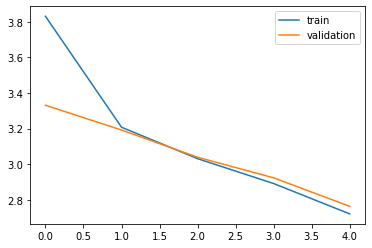

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
#Test 3

In [80]:
from keras.layers import SimpleRNN

In [89]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf

import pandas as pd
import numpy as np
import urllib
import json
import datetime